<a href="https://colab.research.google.com/github/dequiroz/1MTR53_RobIA/blob/main/Filtro_Kalman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://drive.google.com/uc?export=view&id=1FsTa2YzWwxY-HBkd2EOXAlkPJ1zpikWv" alt="drawing" width="150"/>


<p align="center">
<img src="https://drive.google.com/uc?export=view&id=1VBn7nKlruxCPLHH_UuD8B2pkvKP7JLRd" alt="drawing" width="800"/>

</br>

<img src="https://drive.google.com/uc?export=view&id=1uF_4x1YqLuS3M0mlh3NrMrEUHvjBMBFw" alt="drawing" width="800"/>
</p>

#Filtro de Kalman
* Diego Quiroz Velasquez
* Pontificia Universidad Católica del Perú
* Sección Ingeniería Mecatrónica

---
Este archivo describe ...

<img src="https://drive.google.com/uc?export=view&id=1vgFoFHEKMN0WcAFlKS2hPMg2KuBm3sp9" alt="drawing"/>



# Introducción a Gaussianas

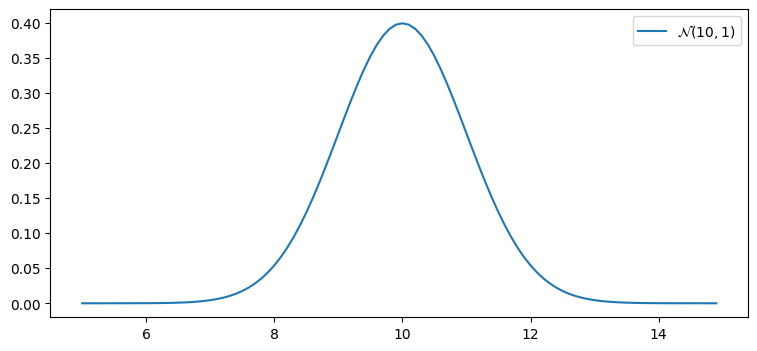

In [82]:
import numpy as np
from math import pi
import matplotlib.pyplot as plt

def data_gaussian(x, mean, var):
  return  ((2*pi*var)**-.5) * np.exp((-0.5*(np.asarray(x)-mean)**2.) / var)

def plot_gaussian(mean, var, xs=None, show=True, ls='-'):
  if show:
    plt.figure(figsize=(9,4))
  if xs is None:
    xs = np.arange(5, 15, 0.1)

  ys = [data_gaussian(x, mean, var) for x in xs]
  plt.plot(xs, ys, ls=ls, label='$\mathcal{N}$' + f'$({mean},{var})$')

  if show:
    plt.legend();
    plt.show()

plot_gaussian(10,1)

Para representar gaussianas en python de forma simple podemos usar la clase `namedtuple`, la cual nos permite crear tuplas y definir el nombre de sus elementos

In [83]:
from collections import namedtuple
gaussian = namedtuple('Gaussian', ['promedio', 'varianza'])
gaussian.__repr__ = lambda s: f'𝒩(μ={s[0]:.3f}, 𝜎²={s[1]:.3f})'

Ahora podemos crear e imprimir gaussianas empleando:

In [84]:
g1 = gaussian(1.5, 2.3)
g2 = gaussian(promedio=32, varianza=0.5**2)
print(g1)
print(g2)

𝒩(μ=1.500, 𝜎²=2.300)
𝒩(μ=32.000, 𝜎²=0.250)


Y podemos acceder al promedio y varianza con los indices o nombres respectivos

In [85]:
g1.promedio, g1[0], g1[1], g1.varianza

(1.5, 1.5, 2.3, 2.3)

## Predicción (movimiento) mediante el uso de gaussianas

Sabemos que la suma de dos gaussianas está dada por

$$\begin{gathered}
\mu = \mu_1 + \mu_2 \\
\sigma^2 = \sigma^2_1 + \sigma^2_2
\end{gathered}$$

para comprender este hecho podemos considerar un caso de un robot móvil con posición conocida $x$ que realiza un proceso se desplazamiento a velocidad constante $f_x$.

Tanto la posición como la velocidad del robot presentan incertidumbres, por lo que podemos modelar su comportamiento empleando gaussianas. Si consideramos que el robot movil se encuenta a 5 m del origen con una incertidumbre de desviación standard 0.2 podemos expresar la  obtener posición como $x=\mathcal N(5, 0.2^2)$

Adicionalmente, podemos expresar una velocidad de desplazamiento de 0.5 m/s con una incertidumbre de 0.1 m/s como $f_x = \mathcal N (0.5, 0.1^2) $

Si sumamos estas representaciones gauseanas del movimiento del robot para representar la nueva posición del robot el siguiente valor $\bar x$ con una nueva incertidumbre $\bar\sigma^2$:

$$\begin{aligned}\bar x &= \mu_x + \mu_{f_x} = 5 + 0.5 &&= 5.5 \\
\bar\sigma^2 &= \sigma_x^2 + \sigma_{f_x}^2 = 0.2^2 + 0.1^2 &&= 0.05 = 0.22^2\end{aligned}$$

Analizando este resultado, podemos observar que la variación en la posición tiene sentido - esta se expresa como la posición anterior más el movimiento realizado.
Sin embargo, la varianza es más dificil de entender de forma intuitiva. Para ello debemos recordar que cuando hacemos una predicción luego a un movimiento perdemos información, lo cual se traduce a una disminución en nuestra confianza (aumento en la varianza). $\sigma_{f_x}^2$ es la cantidad de incertidumbre agregada al sistema debido a la predicción imperfecta sobre el movimiento, por lo que agregaríamos eso a la incertidumbre existente.


Empleando nuestra definición de suma de varianzas podemos implementar una función de predicción que reciba una `posición` y `movimiento` en la forma ($\mu$, $\sigma^2$)

In [86]:
def predict(pos, movimiento):
    return gaussian(pos.promedio + movimiento.promedio, pos.varianza + movimiento.varianza)

Probamos la función con el ejemplo proporcionado

In [87]:
pos = gaussian(5,0.2**2)
movimiento = gaussian(0.5,0.1**2)

predict(pos, movimiento)

𝒩(μ=5.500, 𝜎²=0.050)

##Actualización (medición) mediante el uso de gaussianas

Sabemos que la actualización de los estados la realizamos multiplicando la distribución de posición actual con la certeza que tenemos en la medición. Esta operación podemos realizarza mediante una multiplicación de gaussianas, la cual está dada por

$$\begin{aligned}
\mu &= \frac{\sigma_1^2 \mu_2 + \sigma_2^2 \mu_1} {\sigma_1^2 + \sigma_2^2}, \\
\sigma^2 &= \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2}
\end{aligned}$$

Podemos observar que la media de dos productos de gaussianas es una suma podendara de las medias previas (conocimiento previo de la posición y la medición), donde las varianzas nos permiten determinar si confiamoz más en la medición (sensor preciso) o nuestra predicción (modelo preciso).
Además podemos observar que la nueva varianza es independiente de las medias.

Esta operación la podemos expresar en una función que realiza la actualización

In [88]:
def producto_gaussiana(g1, g2):
    promedio = (g1.varianza * g2.promedio + g2.varianza * g1.promedio) / (g1.varianza + g2.varianza)
    varianza = (g1.varianza * g2.varianza) / (g1.varianza + g2.varianza)
    return gaussian(promedio, varianza)

def update(prior, medicion):
    posterior = producto_gaussiana(medicion, prior)
    return posterior

posicion_predecida = gaussian(10., .2**2)
posicion_medida = gaussian(11., .1**2)
posicion_estimada = update(posicion_predecida, posicion_medida)
print(posicion_estimada)

𝒩(μ=10.800, 𝜎²=0.008)


## Ejemplos interactivo

In [89]:
# @title funciones auxiliares para graficar
import matplotlib.pyplot as plt

def plot_three_gaussians(g1, g2, result, xs=None):
    plt.figure()
    if xs is None:
        xs = np.arange(5, 15, 0.1)

    # el caracters * antes de una tupla o lista realiza un "desenpaquetado" (unpack)
    # En otras palabras envía el contenido dato por dato. En este caso escribit
    # *g1 equivale a g1.promedio, g1.varianza
    plot_gaussian(*g1, xs=xs, show=False)
    plot_gaussian(*g2, xs=xs, show=False)
    plot_gaussian(*result, xs=xs, show=False, ls='--')

    plt.legend();
    plt.show()


def plot_products(g1, g2):
    producto = producto_gaussiana(g1, g2)
    xs = np.arange(5, 15, 0.1)
    plot_three_gaussians(g1, g2, producto, xs)

def plot_sum(g1, g2):
    suma = predict(g1, g2)
    xs = np.arange(0, 10, 0.1)
    plot_three_gaussians(g1, g2, suma, xs)

In [90]:
# @title Función interactiva de suma
from ipywidgets import interact

def suma_gaussiana_interactiva(m1, m2, v1, v2):
    g1 = gaussian(m1, v1)
    g2 = gaussian(m2, v2)
    plot_sum(g1, g2)

interact(suma_gaussiana_interactiva,
         m1=(1., 4.5, .5), m2=(1., 5, .5),
         v1=(.1, 2, .1), v2=(.1, 2, .1));

interactive(children=(FloatSlider(value=2.5, description='m1', max=4.5, min=1.0, step=0.5), FloatSlider(value=…

In [91]:
# @title Función interactiva de producto
from ipywidgets import interact

def producto_gaussiana_interactiva(m1, m2, v1, v2):
    g1 = gaussian(m1, v1)
    g2 = gaussian(m2, v2)
    plot_products(g1, g2)

interact(producto_gaussiana_interactiva,
         m1=(5, 10., .5), m2=(10, 15, .5),
         v1=(.1, 2, .1), v2=(.1, 2, .1));

interactive(children=(FloatSlider(value=7.5, description='m1', max=10.0, min=5.0, step=0.5), FloatSlider(value…

#Aplicación del Filtro de Kalman unidimensional

Previamente hemos definido las funciones de `predict()` y `update()` que nos va a permitir realizar el filtro de kalman empleando distribuciones gaussianas para la posición y movimiento de un robot movil.

Para poder probar y demostrar su funcionamiento, vamos a definir una clase `Robot_Simulacion` que nos va a permitir representar un robot con desplazamiento y mediciones imprecisas

In [92]:
# @title class Robot_simulacion()
from numpy.random import randn
from math import sqrt

class Robot_simulacion():
  def __init__(self, x0=0., desplazamiento=1, varianza_medicion=0.0, varianza_proceso=0.0):
    self.x = x0
    self.desplazamiento = desplazamiento
    self.medicion_std = sqrt(varianza_medicion)
    self.proceso_std = sqrt(varianza_proceso)
  def mover(self):
    """Retorna nueva posicion del robot en metros"""
    dx = self.desplazamiento + randn()*self.proceso_std #se agrega ruido de proceso (desplazamiento)
    self.x += dx
  def medir_posicion(self):
    """Retorna medicion de la posicion actual del robot"""
    medicion = self.x + randn()*self.medicion_std #Se agrega ruido de medicion
    return medicion
  def mover_y_sensar(self):
    """Mueve el robot y retorna una nueva medicion"""
    self.mover()
    return self.medir_posicion()

robot = Robot_simulacion(varianza_medicion=0.3, varianza_proceso=0.1)
robot.mover_y_sensar()

0.373549996333019

Empleando esta clase podemos realizar una simulación en la cual el robot se desplaza 10 veces y se generan las mediciones que se realizan luego de cada iteración

In [93]:
varianza_proceso = 1. # Varianza (incertidumbre) del movmiento del robot
varianza_sensor = 2. # Varianza (incertidumbre) de la medición del sensor

# Posición del robot. Sin conocimiento inicial N(0, 50**2)
x = gaussian(0., 50.**2)
velocidad = 1
dt = 1 # cada cuanto tiempo se realiza una acción en segundos

modelo_proceso = gaussian(velocidad*dt, varianza_proceso) # desplazamiento para agregar a x

# Ejecutar simulacion de movimiento de robot y tomar mediciones
robot = Robot_simulacion(
    x0 = x.promedio,
    desplazamiento = modelo_proceso.promedio,
    varianza_medicion = varianza_sensor,
    varianza_proceso = modelo_proceso.varianza)

# create list of measurements
zs = [robot.mover_y_sensar() for _ in range(10)]
print(zs)

[1.9991891364665693, -0.5445512708375926, 1.8242231423323991, 5.339147031709553, 7.2822597654376935, 8.674272125575648, 11.071812658754634, 12.155498926285922, 13.924179328396047, 15.102400834234103]


Y con esto podemos programar un filtro de Kalman empleando las funciones de prección y actualización

In [94]:
x = gaussian(0., 400)

print(f"{'Iteración':^10}, {'Prediccion':^18}, {'Medición':^10}, {'Actualizacion':^17}")
print(f"{'':_^60}")


# Aplicacion del filtro de Kalman
for i, z in enumerate(zs):
  prior = predict(x, modelo_proceso)
  likelihood = gaussian(z, varianza_sensor)
  x = update(prior, likelihood)

  print(f'{i:^10}', end=',')
  print(f'{prior[0]:^7.3f}, {prior[1]:^9.3f}', end=',')
  print(f'{z:^11.3f}', end=',')
  print(f'{x[0]:^7.3f}, {x[1]:^8.3f}')

print()
print(f'Posición final estimada: {x.promedio}')
print(f'Posición final real: {robot.x}')

Iteración ,     Prediccion    ,  Medición ,   Actualizacion  
____________________________________________________________
    0     , 1.000 ,  401.000 ,   1.999   , 1.994 ,  1.990  
    1     , 2.994 ,   2.990  ,  -0.545   , 0.874 ,  1.198  
    2     , 1.874 ,   2.198  ,   1.824   , 1.848 ,  1.047  
    3     , 2.848 ,   2.047  ,   5.339   , 4.108 ,  1.012  
    4     , 5.108 ,   2.012  ,   7.282   , 6.198 ,  1.003  
    5     , 7.198 ,   2.003  ,   8.674   , 7.937 ,  1.001  
    6     , 8.937 ,   2.001  ,  11.072   ,10.005 ,  1.000  
    7     ,11.005 ,   2.000  ,  12.155   ,11.580 ,  1.000  
    8     ,12.580 ,   2.000  ,  13.924   ,13.252 ,  1.000  
    9     ,14.252 ,   2.000  ,  15.102   ,14.677 ,  1.000  

Posición final estimada: 14.677258468778136
Posición final real: 15.339832530632966


In [95]:
# @title def plot_kalman()

def plot_kalman(zs, xs, predicciones=None, var=None, actual=None):

  xs = np.array(xs)[:,0].flatten()
  x_axis = range(len(zs))

  plt.cla()
  plt.scatter(x_axis, zs, edgecolor='k', facecolor='none', lw=2, label='Mediciones')
  plt.plot(x_axis, xs, color='b', label='Filtro')

  if actual is not None:
    plt.plot(actual, linestyle=':', color='green', label='Actual')

  if predicciones is not None:
    #predicciones = np.array(predicciones)
    plt.scatter(x_axis, predicciones, marker='v', s=40, edgecolor='r', facecolor='None', lw=2, label='Prediciones')
  if var is not None:
    #var = np.asarray(var)
    std = np.sqrt(var)
    std_top = xs+std
    std_btm = xs-std
    plt.plot(x_axis, std_top, linestyle=':', color='purple', lw=1)
    plt.plot(x_axis, std_btm, linestyle=':', color='purple', lw=1)
    plt.fill_between(x_axis, std_btm, std_top, facecolor='purple', alpha=0.1)

  plt.plot()
  plt.legend()
  np.set_printoptions(precision=4)

def imprimir_varianzas(xs):
  print(np.array(xs)[:,1])

[4.4502 2.6507 2.2871 2.1955 2.1712 2.1647 2.1629 2.1625 2.1623 2.1623
 2.1623 2.1623 2.1623 2.1623 2.1623 2.1623 2.1623 2.1623 2.1623 2.1623
 2.1623 2.1623 2.1623 2.1623 2.1623]


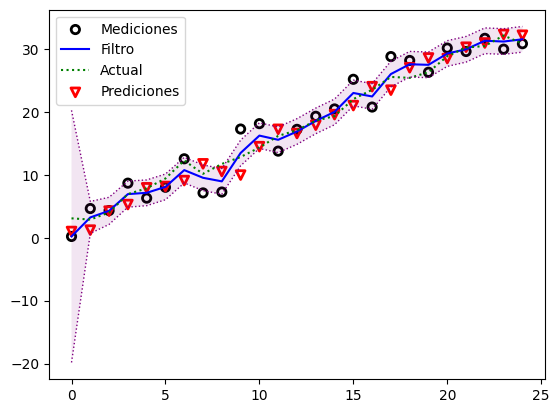

In [96]:
varianza_proceso = 2
varianza_sensor = 4.5
x = gaussian(0., 400)
modelo_proceso = gaussian(1., varianza_proceso)
N = 25

robot = Robot_simulacion(x.promedio, modelo_proceso.promedio, varianza_sensor, varianza_proceso)
zs, x_real = [], []
for _ in range(N):
  zs.append(robot.mover_y_sensar())
  x_real.append(robot.x)

#zs = [robot.mover_y_sensar() for _ in range(N)]
# Variables para almacenar datos
xs, predicciones = [], []

# Aplicacion del filtro de Kalman
for i, z in enumerate(zs):
  prior = predict(x, modelo_proceso)
  likelihood = gaussian(z, varianza_sensor)
  x = update(prior, likelihood)

  predicciones.append(prior)
  xs.append(x)

predicciones = np.array(predicciones)
plot_kalman(zs, xs, predicciones[:,0], var=predicciones[:,1], actual=x_real)
imprimir_varianzas(xs)

Se puede observar que la varianza converge a 2.1623 luego de 8 iteraciones. Esto implica que podemos decir con confianza cual es la posición del robot.

Esta varianza implica una desviación estandar de $\sigma=1.47$ metros, la cual podemos comparar con la del sensor ($\sigma=2.12$). Esto implica que nuestro filtro de Kalman a logrado obtener una presición **mayor** que si solo se leyera la data del sensor sin procesarla. Al inicio la varianza obtenida por el filtro es mayor, pero rápidamente se logra estabilizar y obtener una mejor estimación.



## Ejercicio: Modificar varianzas

Modificar los valores de `varianza_proceso` y `varianza_sensor` y observar el efecto que tienen sobre el filtro y la varianza final obtenida. ¿Cual tiene un efecto mayor sobre la convergencia de la varianza? Por ejemplo, cual de los dos siguientes resulta en una menor varianza:


```python
varianza_proceso = 40
varianza_sensor = 2
```
    
o:

```python
varianza_proceso = 2
varianza_sensor = 40
```

#Filtro de Kalman

Se ha podido observar que el filtro de Kalman funciona. Ahora analicemos la matemática detras del filtro

##Ganancia de Kalman

Sabemos que el filtro de Kalman realiza una actualización (**update**) sobre un estado previo (**prior**), el cual se realiza mediante un producto de gaussianas. Por lo tanto, el promedio del resultado **posterior** está dado por

$$
\mu=\frac{\bar\sigma^2\, \mu_z + \sigma_z^2 \, \bar\mu} {\bar\sigma^2 + \sigma_z^2}
$$

Donde empleamos el indice $z$ para denominar una medición. Esta ecuación se puede reescribir de la siguiente manera

$$
\mu = \left( \frac{\bar\sigma^2}{\bar\sigma^2 + \sigma_z^2}\right) \mu_z + \left(\frac{\sigma_z^2}{\bar\sigma^2 + \sigma_z^2}\right)\bar\mu
$$

En esta estructura es facil ver que el filtro de Kalman realiza un "escalamiento" entre la medición y el estado previo (prior) por lo pesos dados

$$\mu = W_1 \mu_z + W_2 \bar\mu$$

Estos pesos deben de sumar 1 debido a que el denominador es un término de normalización. Lo cual nos permite introducir un nuevo término $K=W_1$ resultando en la siguiente ecuación:

$$\begin{aligned}
\mu &= K \mu_z + (1-K) \bar\mu\\
&= \bar\mu + K(\mu_z - \bar\mu)
\end{aligned}$$

donde

$$K = \frac {\bar\sigma^2}{\bar\sigma^2 + \sigma_z^2}$$

se define como la ganancia de Kalman (***Kalman gain***). Está variable es la esencia del filtro de Kalman. Es un término que nos permite escoger un valor entre $\mu_z$ and $\bar\mu$. En otras palabras, en que confiamos más ... la medición del sensor, o la predicción realizada mediante un modelo matemático.

Esto se puede comprender mediante el siguiente esquema.
La ganancia de Kalman $K$ es el factor de escala que elije un valor en el residual.

<img src="https://drive.google.com/uc?export=view&id=1xIz4xXvWAkJPXZecvctvbP4uvnTp1Uab" alt="Esquema de Filtro de Kalman"/>

Con estas definiciones se puede realizar otras implementaciones equivalentes de las funciones `update()` y  `predict()`:

In [97]:
def update(prior, measurement):
    x, P = prior        # promedio and varianza del prior
    z, R = measurement  # promedio and varianza de la medicion

    y = z - x        # residual
    K = P / (P + R)  # Kalman gain

    x = x + K*y      # posterior
    P = (1 - K) * P  # Varianza de posterior
    return gaussian(x, P)

def predict(posterior, movement):
    x, P = posterior # promedio y varianza del posterior
    dx, Q = movement # promedio y varianza del movimiento
    x = x + dx
    P = P + Q
    return gaussian(x, P)

Estas definiciones pueden verse más complicadas (y lo son). Sin embargo, se presentas así debido a que el nombre de las variables presentadas es el estandar para el filtro de Kalman.

`z`, `P`, `Q`, y `R`provienen de la historia de la teoría de control (el filtro fue propuesto en el año 1960) y debido a que todo artículo y libro que menciona el filtro usa estas variables, deben de acostumbrarse a ellas. $R$ representa el ruido de medición, $Q$ el ruido del proceso y $P$ la varianza del estado mientas que $z$ es la medición realizada.

## Ejemplo: Cantidad de ruido extremo

Hasta ahora hemos considerado casos sin mucho ruido y considerabamos como posición inicial del robot cero. Pero, como funciona el sensor en casos reales?

Analizaremos el desempeño del filtro agregando ruido extremo al sensor de posicionamiento (ultrasonido, laser, infrarojo, etc).

¿Que podemos inferir si el sensor tiene una desviación estandar de 300 metros? En otras palabras que si la posición real es de 5 metros podría ser reportada como 245.7 o -421.3.

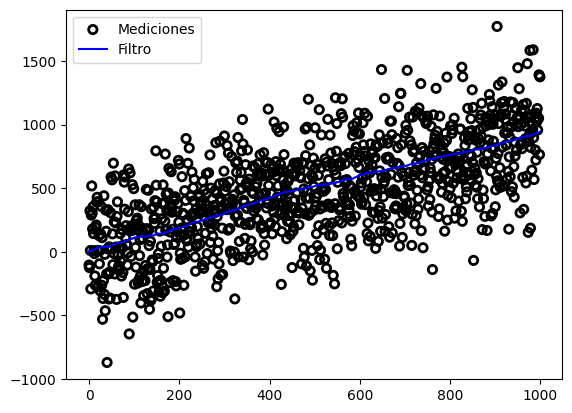

In [98]:
varianza_proceso = 2
varianza_sensor = 300**2
x = gaussian(0., 400)
modelo_proceso = gaussian(1., varianza_proceso)
N = 1000

# Simulacion de movimiento del robot
robot = Robot_simulacion(x.promedio, modelo_proceso.promedio, varianza_sensor, varianza_proceso)
zs = [robot.mover_y_sensar() for _ in range(N)]
# Variables para almacenar datos
xs, predicciones = [], []

# Aplicacion del filtro de Kalman
for i, z in enumerate(zs):
  prior = predict(x, modelo_proceso)
  likelihood = gaussian(z, varianza_sensor)
  x = update(prior, likelihood)

  predicciones.append(prior)
  xs.append(x)

plot_kalman(zs, xs)

En este ejemplo, el ruido es extremo y aun así el filtro genera una línea casi recta. ¿Cuál crees que podría ser la causa de este efecto?

Obtenemos una línea casi recta porque nuestro error de proceso es pequeño. Un pequeño error de proceso le dice al filtro que la predicción es muy confiable y que la predicción es una línea recta, por lo que el filtro genera una línea casi recta.

## Ejemplo: Varianza de proceso incorrecto

Del ejemplo anterior podemos concluir que una varianza del proceso pequeña en comparación con la del sensor funciona muy buen. ¿Podemos entonces usar una varianza del proceso bien pequeña siempre?

La variación del proceso le dice al filtro como cambia el sistema en el tiempo. Si se le da un valor incorrecto al filtro y se proporciona un valor artificialmente bajo, el filtro no podrá reaccionar antes los cambios que sucedan.

Hagamos que el robot aumente su velocidad en una pequeña cantidad en cada intervalo de tiempo y veamos cómo funciona el filtro con una variación del proceso de 0,001 m$^2$.

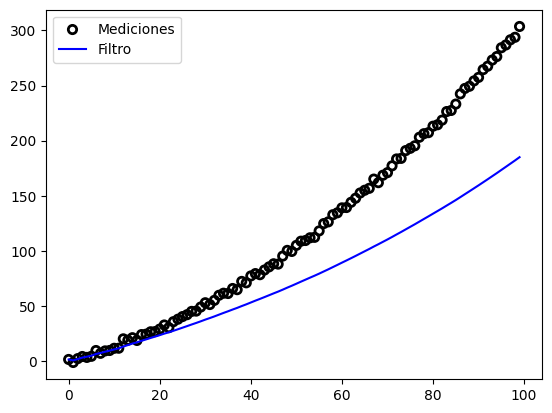

In [99]:
varianza_proceso = 0.001
varianza_sensor = 4.5
x = gaussian(0., 400)
modelo_proceso = gaussian(1., varianza_proceso)
N = 100

# Simulacion de movimiento del robot
robot = Robot_simulacion(x.promedio, modelo_proceso.promedio, varianza_sensor, varianza_proceso)
#zs = [robot.mover_y_sensar() for _ in range(N)]
# Variables para almacenar datos
zs, xs, predicciones = [], [], []
for _ in range(N):
  robot.desplazamiento += 0.04
  zs.append(robot.mover_y_sensar())

# Aplicacion del filtro de Kalman
for i, z in enumerate(zs):
  prior = predict(x, modelo_proceso)
  likelihood = gaussian(z, varianza_sensor)
  x = update(prior, likelihood)

  predicciones.append(prior)
  xs.append(x)

plot_kalman(zs, xs)

Se puede apreciar que el filtro no responde correctamente y no considera a las mediciones que claramente indican que el robot está cambiando su velocidad, pero al filtro se le ha indicado que sus predicciones son casi perfectas, por lo que ignora las mediciones.

El filtro de Kalman no es mágico, hay que diseñarlo con valores de varianza adecuados para que pueda responder de forma correcta.

## Ejemplo: Mal estimación inicial

Ahora veamos los resultados cuando hacemos una mala estimación inicial de la posición. Para apreciar un poco mejor, se aumenta la varianza del sensor a 25 pero se establece la posición inicial en 1000 metros. ¿Puede el filtro recuperarse de un error de 1000 metros?

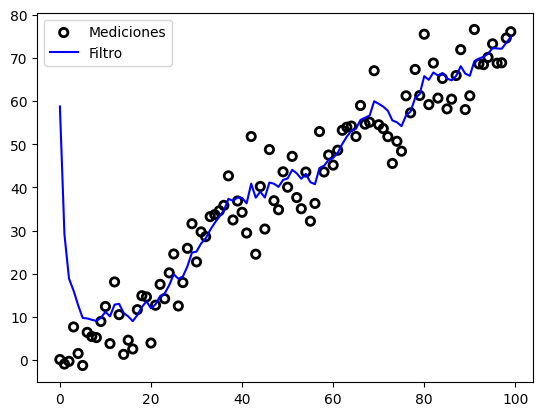

In [100]:
varianza_proceso = 2
varianza_sensor = 25
x = gaussian(1000., 400)
modelo_proceso = gaussian(1., varianza_proceso)
N = 100

# Simulacion de movimiento del robot
robot = Robot_simulacion(0, modelo_proceso.promedio, varianza_sensor, varianza_proceso)
zs = [robot.mover_y_sensar() for _ in range(N)]
# Variables para almacenar datos
xs, predicciones = [], []

# Aplicacion del filtro de Kalman
for i, z in enumerate(zs):
  prior = predict(x, modelo_proceso)
  likelihood = gaussian(z, varianza_sensor)
  x = update(prior, likelihood)

  predicciones.append(prior)
  xs.append(x)

plot_kalman(zs, xs)

Debido a que estamos relativamente seguros en el sensor ($\sigma^2=5^2$), después de la primeta iteración, hemos cambiado nuestra estimación de posición de 1000 m a aproximadamente 50 m. Después de otras 5-10 mediciones hemos convergido al valor correcto. Se puede apreciar que errores iniciales no afectar mucho el desempeño, el filtro de Kalman converge siempre que las varianzas del filtro se seleccionen para coincidir con el proceso real y las varianzas de medición.

**En la práctica este problema se soluciona seleccionando la primera medición del sensor como valor inicial.**


## Ejemplo: Error inicial y ruido extremo

¿Podra el filtro funcionar bien bajo las peores condiciones?

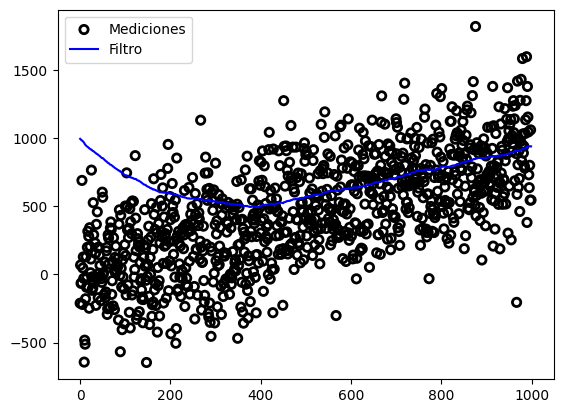

In [101]:
varianza_proceso = 2
varianza_sensor = 300**2
x = gaussian(1000., 400)
modelo_proceso = gaussian(1., varianza_proceso)
N = 1000

# Simulacion de movimiento del robot
robot = Robot_simulacion(0, modelo_proceso.promedio, varianza_sensor, varianza_proceso)
zs = [robot.mover_y_sensar() for _ in range(N)]
# Variables para almacenar datos
xs, predicciones = [], []

# Aplicacion del filtro de Kalman
for i, z in enumerate(zs):
  prior = predict(x, modelo_proceso)
  likelihood = gaussian(z, varianza_sensor)
  x = update(prior, likelihood)

  predicciones.append(prior)
  xs.append(x)

plot_kalman(zs, xs)

Esta vez el filtro tiene dificultades y requiere más de 600 o 700 iteraciones para converger en un valor. Los filtro de kalman no son mágicos por lo que no pueden solucionar todos los problemas.

Problemos empleando la primera medición como valor inicial

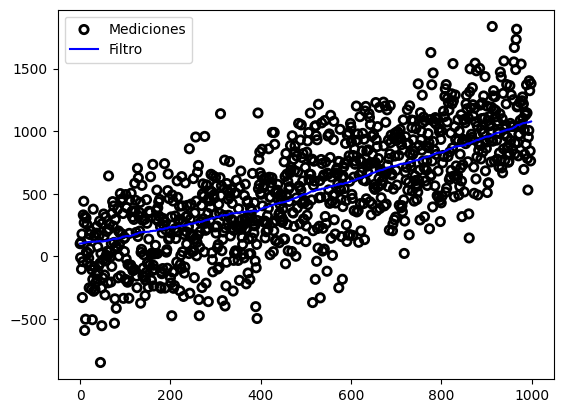

In [102]:
varianza_proceso = 2
varianza_sensor = 300**2

modelo_proceso = gaussian(1., varianza_proceso)
N = 1000

# Simulacion de movimiento del robot
robot = Robot_simulacion(0, modelo_proceso.promedio, varianza_sensor, varianza_proceso)
zs = [robot.mover_y_sensar() for _ in range(N)]
x = gaussian(zs[0], 400)

# Variables para almacenar datos
xs, predicciones = [], []

# Aplicacion del filtro de Kalman
for i, z in enumerate(zs):
  prior = predict(x, modelo_proceso)
  likelihood = gaussian(z, varianza_sensor)
  x = update(prior, likelihood)

  predicciones.append(prior)
  xs.append(x)

plot_kalman(zs, xs)

Observar como este cambio logro una mejora significativa sobre el desempeño del filtro. Que tan rápido converja el filtro va a depender del ruido presente en la primera medición; sin embargo, observar que en este ejemplo el ruido considerado es extremo ... Los sensores comerciales suelen tener ruido de decimas o centesimas de unidades, en el ejemplo estamos empleando 300^2

## Ejemplo interactivo

In [103]:
from ipywidgets import interact, FloatSlider

def plot_kalman_filter(pos_ini, ruido_sensor, desplazamiento, ruido_proceso):
  # Agregar el código aqui

  # Agregar el código aqui
  plt.figure()
  plt.plot(zs, c='k', marker='o', linestyle='', label='measurement')
  plt.plot(xs, c='#004080', alpha=0.7, label='filter')
  plt.legend(loc=4);
  plt.show()


interact(plot_kalman_filter,
         pos_ini=(-10, 10),
         ruido_sensor=FloatSlider(value=5, min=0, max=100),
         desplazamiento=FloatSlider(value=1, min=-2., max=2.),
         ruido_proceso=FloatSlider(value=5, min=0, max=100.));

interactive(children=(IntSlider(value=0, description='pos_ini', max=10, min=-10), FloatSlider(value=5.0, descr…

In [104]:
# @title Solucion

from ipywidgets import interact, FloatSlider

def plot_kalman_filter(pos_ini, ruido_sensor, desplazamiento, ruido_proceso):
    # Agregar el código aqui
    N = 20
    # Simulacion de movimiento del robot
    robot = Robot_simulacion(pos_ini, desplazamiento, ruido_sensor, ruido_proceso)
    zs = [robot.mover_y_sensar() for _ in range(N)]

    x = gaussian(zs[0], 400) # promedio y varianza de estimacion inicial
    modelo_proceso = gaussian(desplazamiento, ruido_proceso)

    # Variables para almacenar datos
    xs = []

    # Aplicacion del filtro de Kalman
    for z in zs:
      x = predict(x, modelo_proceso)
      x = update(x, gaussian(z, ruido_sensor))

      xs.append(x.promedio)

    plt.figure()
    plt.plot(zs, c='k', marker='o', linestyle='', label='measurement')
    plt.plot(xs, c='#004080', alpha=0.7, label='filter')
    plt.legend(loc=4);
    plt.show()

interact(plot_kalman_filter,
         pos_ini=(-10, 10),
         ruido_sensor=FloatSlider(value=5, min=0, max=100),
         desplazamiento=FloatSlider(value=1, min=-2., max=2.),
         ruido_proceso=FloatSlider(value=5, min=0, max=100.));

interactive(children=(IntSlider(value=0, description='pos_ini', max=10, min=-10), FloatSlider(value=5.0, descr…

#Filtro de Kalman Multivariante

El filtro de Kalman multivariante, emplea el concepto de gaussianas para cada variable a predecir. Expresando cada una en una dimensión como se muestra a continuación

<img src="https://drive.google.com/uc?export=view&id=1oRcthZZsMqxi1QvJvCo4YCDqoBaINEyS" alt="gaussian 2 dimension" width=500px/>

Esto permite representar multiples variables de forma sencilla y demuestra el verdadeo potencial del filtro de Kalman. Sin embargo, la matemática se complica ligeramente por lo que se debe emplear algebra lineal.

A continuación se presentan las ecuaciones completas del filtro de Kalman

<u>**Predición**</u>

$\begin{array}{|l|l|l|}
\hline
\text{Univariante} & \text{Univariante} & \text{Multivariante}\\
& \text{(Forma de Kalman)} & \\
\hline
\bar \mu = \mu + \mu_{f_x} & \bar x = x + dx & \bar{\mathbf x} = \mathbf{Fx} + \mathbf{Bu}\\
\bar\sigma^2 = \sigma_x^2 + \sigma_{f_x}^2 & \bar P = P + Q & \bar{\mathbf P} = \mathbf{FPF}^\mathsf T + \mathbf Q \\
\hline
\end{array}$

sin preocuparse por los detalles del algebra lineal, se puede observar que:

$\mathbf x,\, \mathbf P$ representan el promedio y covarianza del estado y corresponden a $x$ y $\sigma^2$.

$\mathbf F$ se denomina función de transición de estado. Representa el proceso que se realiza (por ejemplo, movimiento). Cuando se multiplica por $\bf x$ se optiene el estado previo (**prior**).

$\mathbf Q$ es la covarianza del proceso (por ejemplo, incertidumbre del movimiento). Corresponde a $\sigma^2_{f_x}$.

$\mathbf B$ and $\mathbf u$ son nuevos términos que permiten modelar las entradas de control. Por ejemplo, las señales de acción de un actuador.

<u>**Actualización**</u>

$\begin{array}{|l|l|l|}
\hline
\text{Univariante} & \text{Univariante} & \text{Multivariante}\\
& \text{(Forma de Kalman)} & \\
\hline
& y = z - \bar x & \mathbf y = \mathbf z - \mathbf{H\bar x} \\
& K = \frac{\bar P}{\bar P+R}&
\mathbf K = \mathbf{\bar{P}H}^\mathsf T (\mathbf{H\bar{P}H}^\mathsf T + \mathbf R)^{-1} \\
\mu=\frac{\bar\sigma^2\, \mu_z + \sigma_z^2 \, \bar\mu} {\bar\sigma^2 + \sigma_z^2} & x = \bar x + Ky & \mathbf x = \bar{\mathbf x} + \mathbf{Ky} \\
\sigma^2 = \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2} & P = (1-K)\bar P &
\mathbf P = (\mathbf I - \mathbf{KH})\mathbf{\bar{P}} \\
\hline
\end{array}$

$\mathbf H$ representa la función de medición, este es un efecto nuevo que se explicará a detalle. Básicamente, permite relacionar el estado con la mediciones realizadas para obtener el "error de predicción" (**residual**)

$\mathbf z,\, \mathbf R$ representan el promedio y covarianza de la medición. Corresponden a $z$ y $\sigma_z^2$

$\mathbf y$ y $\mathbf K$ son el residual y la ganancia de Kalman.

La principal diferencia es el uso de vectores y matrices para representar el estado, pero los conceptos son los mismos que en el caso univariante:
- Representar la estimación del estado y su incertidumbre mediante una función gaussiana.
- Representar la medición y su error (incertidumbre)
- Representar el modelo del proceso con una gaussiana
- Usar el modelo del proceso para *predecir* el siguiente estado (prior)
- Usar la ganancia de Kalman para *actualizar* el estado a un valor entre la medición y el prior.

El trabajo a realizar para diseñar un filtro de Kalman es determinar es estado $\left(\mathbf x, \mathbf P\right)$, el proceso $\left(\mathbf F, \mathbf Q\right)$, la medición $\left(\mathbf z, \mathbf R\right)$ y la función de medición $\mathbf H$. Si el sistema tiene entradas de control, como en el caso de un sistema robótico, también se debe diseñar $\mathbf B$ y $\mathbf u$.

## Diseño del modelo del proceso

Para modelar el proceso se debe de considerar las ecuaciones que definen al sistema a modelar.

Por ejemplo, si tomamos el caso del robot movil donde deseamos saber su posición y velocidad, podemos definir el vector de estado $\mathbf{x}$ como

$$\begin{bmatrix} x \\ \dot{x}\end{bmatrix}$$

Además, sabemos que el filtro de Kalman calcula la predicción (**prior**) según la ecuación:

$$\mathbf{\bar x} = \mathbf{Fx}$$

Por lo tanto, para definir el proceso necesitamos obtener la matris F tal que se cumpla de forma explicita:

$$\begin{bmatrix} \bar x \\ \dot{\bar x}\end{bmatrix} = \begin{bmatrix}? & ? \\? & ?\end{bmatrix}\begin{bmatrix}x\\\dot x\end{bmatrix}$$

Para ello, debemos de recordar que las ecuaciones de movimiento se pueden expresar como

$$\begin{cases}
\begin{aligned}
\bar x &= x + \dot x \Delta t \\
\bar{\dot x} &= \dot x
\end{aligned}
\end{cases}$$

Mediante la cual podemos determinar la función de transición F y definir

$$\begin{aligned}
\begin{bmatrix}\bar x \\ \bar{\dot x}\end{bmatrix} &= \begin{bmatrix}1&\Delta t  \\ 0&1\end{bmatrix}  \begin{bmatrix}x \\ \dot x\end{bmatrix}\\
\mathbf{\bar x} &= \mathbf{Fx}
\end{aligned}$$

Si deseamos realizar un movimiento en 2 dimensiones, el resultado sería

$$\begin{aligned}
\begin{bmatrix}\bar x \\ \bar{\dot x} \\ \bar y \\ \bar{\dot y}\end{bmatrix} &= \begin{bmatrix}1&\Delta t  & 0 & 0\\ 0&1 &0 & 0 \\ 0 & 0 & 1 & \Delta t \\ 0 & 0 & 0 & 1\end{bmatrix}  \begin{bmatrix}x \\ \dot x \\ y \\ \dot y\end{bmatrix}
\end{aligned}$$

</br>

¿Como sería la forma de $\mathbf{F}$ si también se desea estimar la aceleración?

## Diseño de Función de Medición

La función de medición se emplea durante el proceso de actualización para calcular el residual.
Recordemos que previamente el residual se ha calculado según

$$y = z - \bar x $$

Sin embargo, en el caso multivariante se necesita poder determinar que variables del estado se están midiento (no siempre se tiene sensores para cada variable). Adicionalmente, puede hacer el caso de que se cuente con multiples sensores del mismo tipo, por lo que se requiere de una forma de poder separar esta información. Esta es el objetivo de la función de medición - convertir y transformar estados en mediciones.

$$\mathbf y = \mathbf z - \mathbf{H \bar x}$$

Por lo que se requiere diseñar $\mathbf H$ tal que $\mathbf{H\bar x}$ retorne una medición. Para el ejemplo de un robot movil que mide su posición, la medición $\mathbf z$ es un vector de una dimensión:

$$\mathbf z = \begin{bmatrix}z\end{bmatrix}$$

Por lo que el residual tiene la forma de:

$$
\begin{aligned}
\textbf{y} &= \mathbf z - \mathbf{H\bar x}  \\
\begin{bmatrix}y \end{bmatrix} &= \begin{bmatrix}z\end{bmatrix} - \begin{bmatrix}?&?\end{bmatrix} \begin{bmatrix}x \\ \dot x\end{bmatrix}
\end{aligned}
$$

Como la medición solo contiene información de posición y no velocidad, esto resulta en la siguiente matriz:

$$\begin{aligned}
\textbf{y} = \mathbf z - \begin{bmatrix}1&0\end{bmatrix} \begin{bmatrix}x \\ \dot x\end{bmatrix}
\end{aligned}$$

Si se tuviesen dos sensores, se tendría la siguiente expresión

$$\mathbf z = \begin{bmatrix}z_1 \\ z_2 \end{bmatrix}$$

$$\begin{aligned}
\textbf{y} = \mathbf z - \begin{bmatrix}1&0\\1&0\end{bmatrix} \begin{bmatrix}x \\ \dot x\end{bmatrix}
\end{aligned}$$

y se podría realizar una fusión de sensores considerando la covarianza de ambos para obtener un resultado mejor que el promedio de ellos

Posición final real: 24.763120027355843
Posición final estimada: [23.6774]
Velocidad final estimada: [0.9397]


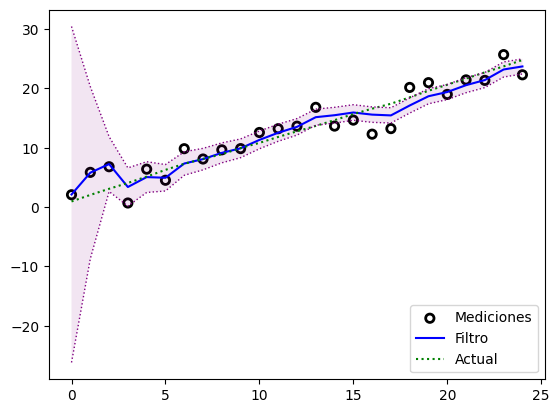

In [105]:
# @title Filtro de Kalman multivariante
from scipy.linalg import inv, block_diag

#np.random.seed(9)
varianza_proceso = 0.01 # Varianza (incertidumbre) del movimiento del robot
varianza_sensor = 4.5 # Varianza (incertidumbre) de la medición del sensor
velocidad = 1
dt = 1 # cada cuanto tiempo se realiza una acción en segundos
count = 25

# Ejecutar simulacion de movimiento de robot y tomar mediciones
robot = Robot_simulacion(
    x0 = 0,
    desplazamiento = velocidad*dt,
    varianza_medicion = varianza_sensor,
    varianza_proceso = varianza_proceso)

# create list of measurements
actual, zs = [], []
for _ in range(count):
  zs.append(robot.mover_y_sensar())
  actual.append(robot.x)

# Matrices de Filtro de Kalman
x = np.array([[5.0, 5]]).T
P = np.diag([400, 400])
F = np.array([[1, dt],
              [0,  1]])
H = np.array([[1., 0.]])
R = np.array([[varianza_sensor]])
# Q Se considera como un ruido blanco discreto
Q = np.array([[0.25*dt**4, 0.5*dt**3],
              [0.5*dt**3,  dt**2]])*varianza_proceso

xs, cov_predic, cov = [], [], []

for z in zs:
  # Predecir
  x = F @ x
  P = F @ P @ F.T + Q

  cov_predic.append(P)

  # Actualizar
  S = H @ P @ H.T + R
  K = P @ H.T @ inv(S)
  y = z - H @ x
  x += K @ y
  P = P - K @ H @ P

  xs.append(x)
  cov.append(P)

cov_predic = np.asarray(cov_predic)
plot_kalman(zs, xs, var=cov_predic[:,0,0], actual=actual)
print(f'Posición final real: {actual[count-1]}')
print(f'Posición final estimada: {xs[count-1][0]}')
print(f'Velocidad final estimada: {xs[count-1][1]}')

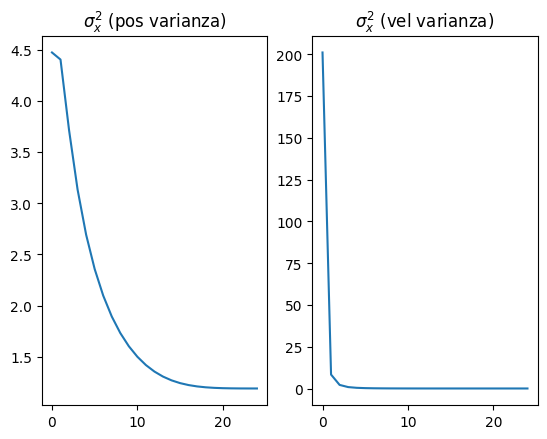

In [106]:
cov = np.asarray(cov)
ax = plt.subplot(121)
ax.set_title(r"$\sigma^2_x$ (pos varianza)")
plt.plot(cov[:,0,0])

ax = plt.subplot(122)
ax.set_title(r"$\sigma^2_x$ (vel varianza)")
plt.plot(cov[:,1,1])

## Efecto de variables ocultas (Velocidad)

En el filtro aplicado se puede observar que la velocidad es una variable oculta, es decir, no existe un sensor que esté midiendo de forma directa este parámetro. Sin embargo, podemos ver como el filtro de Kalman "observa" de forma adecuada el valor de la velocidad.

A continuación se muestra el efecto de esta estimación respecto al deseméño del filtro en comparación con el filtro de Kalman univariante al modificar la velocidad y considerar un proceso con varianza extremadamente baja.

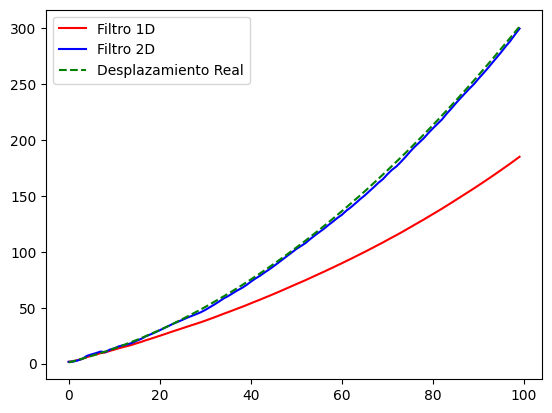

In [107]:
varianza_proceso = 0.001
varianza_sensor = 4.5
x_uni = gaussian(0., 400)
modelo_proceso = gaussian(1., varianza_proceso)
velocidad = 1
dt = 1 # cada cuanto tiempo se realiza una acción en segundos
N = 100

# Matrices de Filtro de Kalman
x = np.array([[5.0, 5]]).T
P = np.diag([400, 400])
F = np.array([[1, dt],
              [0,  1]])
H = np.array([[1., 0.]])
R = np.array([[varianza_sensor]])
# Q Se considera como un ruido blanco discreto
Q = np.array([[0.25*dt**4, 0.5*dt**3],
              [0.5*dt**3,  dt**2]])*varianza_proceso

# Simulacion de movimiento del robot
robot = Robot_simulacion(0, velocidad*dt, varianza_sensor, varianza_proceso)

# Variables para almacenar datos
zs, xs1, actual, xs2 = [], [], [], []
for _ in range(N):
  robot.desplazamiento += 0.04
  zs.append(robot.mover_y_sensar())
  actual.append(robot.x)

for z in zs:
  # Aplicacion del filtro de Kalman Univariante
  prior = predict(x_uni, modelo_proceso)
  likelihood = gaussian(z, varianza_sensor)
  x_uni = update(prior, likelihood)
  xs1.append(x_uni.promedio)

  # Aplicación de filtro de Kalman Multivariante
  # Predecir
  x = F @ x
  P = F @ P @ F.T + Q
  # Actualizar
  S = H @ P @ H.T + R
  K = P @ H.T @ inv(S)
  y = z - H @ x
  x += K @ y
  P = P - K @ H @ P

  xs2.append(x[0])

#plot_kalman(zs, xs)
plt.plot(xs1, color='red', label='Filtro 1D')
plt.plot(xs2, color='blue', label='Filtro 2D')
plt.plot(actual, ls='--', color='green', label='Desplazamiento Real')
plt.legend()
plt.show()

Previamente hemos visto este efecto sobre el filtro de Kalman univariante, en el cual el filtro confia demasiado en el proceso (debido a su baja varianza) y por lo tanto no tiene forma de estimar la velocidad y su cambio durante el proceso.

Por otro lado, se puede observar claramente como el filtro de kalman multivariante no presenta este efecto al contener dentro de su estado una estimación de la velocidad y puede modelar de forma efectiva su cambio en todo momento.